# Prevendo emplacamentos de veículos

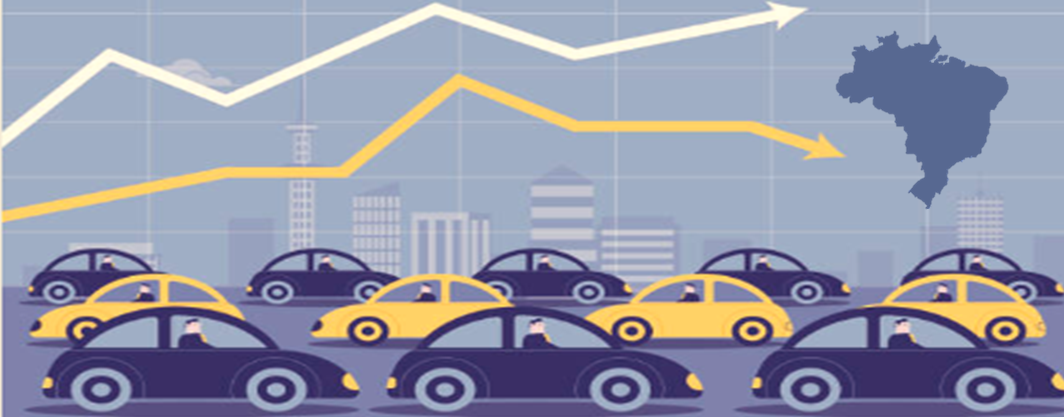

<div class="alert alert-block alert-warning">
<b>Sobre o conteúdo:</b> Este é um projeto pessoal do estudo previsões de séries temporais (registros de informações que ocorrem ao longo do tempo).<br>
<b>Objetivo:</b>
Calcular a previsão de emplacamentos mensais de veículos no mercado automotivo brasileiro.<br>
Conhecer a dimensão do contexto onde o produto está inserido é a primeira camada de informação para acompanhamento e avaliação de performance, bem como identificação das oportunidades de negócio.<br>
Fonte da base de dados: histórico emplacamentos Anfavea (https://anfavea.com.br)<br>

[English]
This is my personal project of time series forecasting study.<br>
Purpose: the goal of this project is to predict the monthly registration of vehicles in Brazil.
    
Link do projeto em meu Github:<br> 
https://github.com/leandroakio/Portfolio/blob/main/Prevendo%20emplacamentos%20mensais%20de%20ve%C3%ADculos.ipynb
</div>



## Etapas do projeto

>1) Importação das bibliotecas necessárias para o projeto. <br>
>2) Carregamento arquivo com os dados para a análise: arquivo excel com emplacamentos mensais obtidos no site da Anfavea. <br>
>3) Análise exploratória dos dados. <br>
>4) Processamento dos dados.<br>
>5) Treino do modelo preditivo.<br>
>6) Cálculo da previsão e acurácia do modelo.<br>
>7) Considerações

### 1) Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

### 2) Carregamento do arquivo com a base de dados

In [2]:
df = pd.read_csv('Emplacamentos_autoecomleves.csv',sep=';',parse_dates=['Date'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           187 non-null    datetime64[ns]
 1   Emplacamentos  187 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 KB


### 3) Análise exploratória

In [3]:
#conferindo dimensão e existencia de registros com valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           187 non-null    datetime64[ns]
 1   Emplacamentos  187 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 KB


In [4]:
#conferindo detalhes estatísticos básicos da amostra
df.describe()

,Emplacamentos
count,187.000000
mean,224941.128342
std,59538.886402
min,51463.000000
25%,183781.500000
50%,221723.000000
75%,273276.500000
max,405478.000000


In [5]:
df.tail(3)

,Date,Emplacamentos
184,2022-05-01,175214
185,2022-06-01,165688
186,2022-07-01,169197


<AxesSubplot:title={'center':'Emplacamento mensal Jan/2007 a Jul/2022'}, xlabel='Date'>

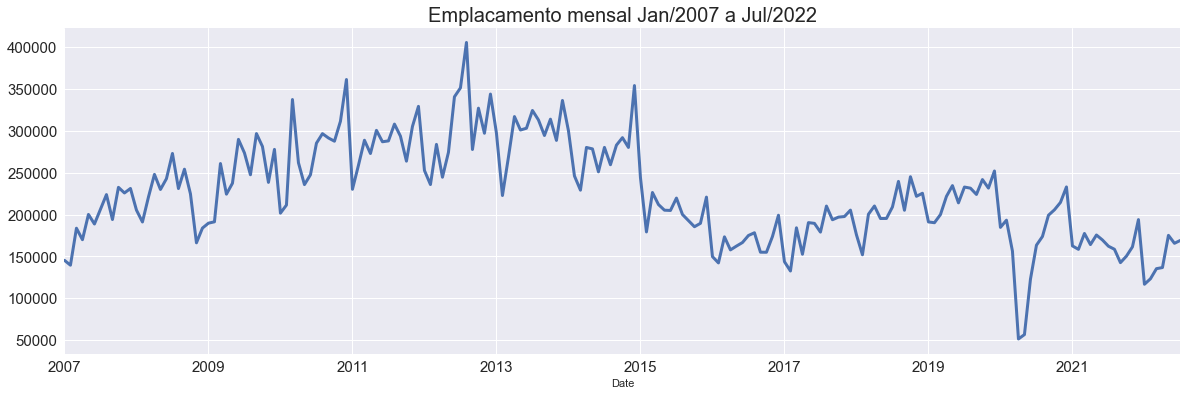

In [6]:
#visualizando os emplacamentos ao longo do período
df.set_index('Date', inplace=True)
plt.title('Emplacamento mensal Jan/2007 a Jul/2022',fontsize=20)
df['Emplacamentos'].plot.line(figsize=(20, 6),linewidth=3, fontsize=15)

A fim de excluir o fator epidemiológico que impactou na sazonalidade, vou considerar resultados de emplacamentos até dez/2019

Text(0.5, 1.0, 'Emplacamentos Automóveis e Comerciais Leves - 2007 a 2019')

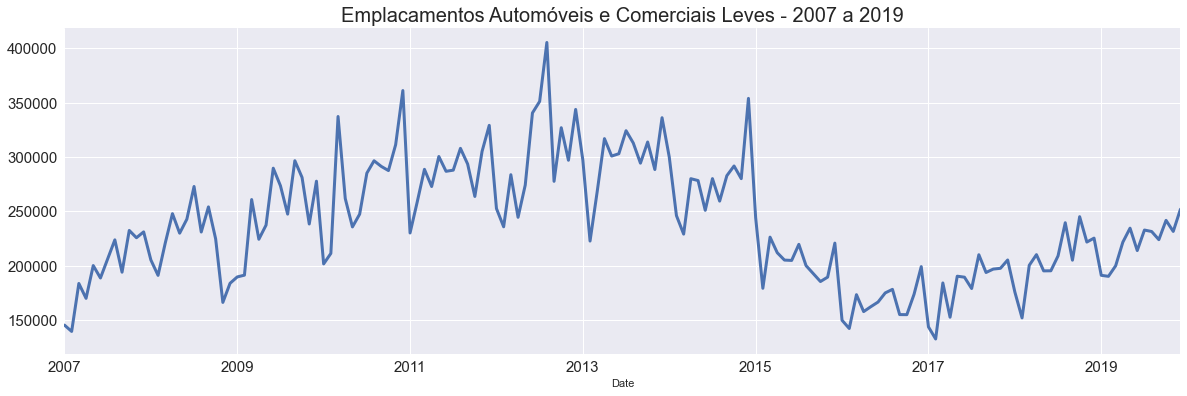

In [7]:
df =df['2007-01-01' :'2019-12-01']
df['Emplacamentos'].plot.line(figsize=(20, 6),linewidth=3, fontsize=15)
plt.title('Emplacamentos Automóveis e Comerciais Leves - 2007 a 2019', fontsize=20)

In [8]:
maior = df[df.Emplacamentos == df.Emplacamentos.max()]
menor = df[df.Emplacamentos == df.Emplacamentos.min()]
print("Maior emplacamento mensal ",maior,"Menor emplacamento mensal ", menor,sep="\n")

Maior emplacamento mensal 
            Emplacamentos
Date                     
2012-08-01         405478
Menor emplacamento mensal 
            Emplacamentos
Date                     
2017-02-01         132625


Agosto de 2018 foi o mês com maior volume de emplacamentos registrados (último mês de alíquota reduzida de IPI + oferta de crédito para financiamentos).

<AxesSubplot:xlabel='Emplacamentos', ylabel='Count'>

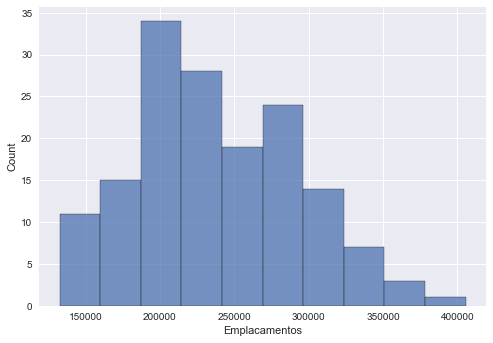

In [9]:
sns.histplot(data=df['Emplacamentos'], bins = 10)

Abaixo, ao analisar as vendas por mês, vemos que as maiores vendas ocorrem nos meses de novembro (black friday) e dezembro (Natal), um sinal de sazonalidade.

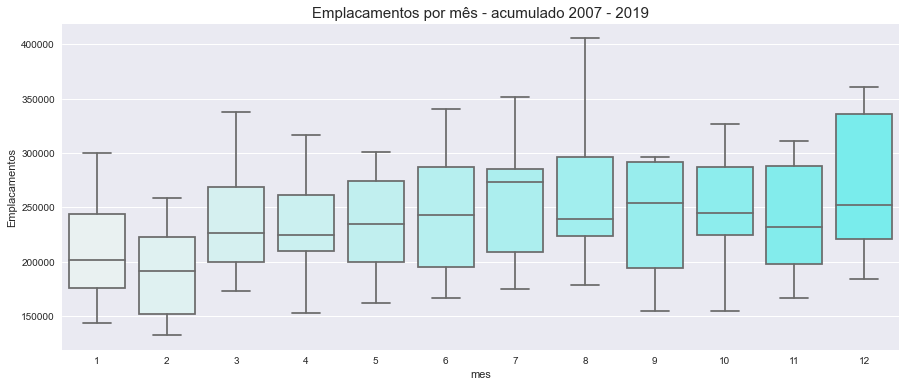

In [10]:
df['mes'] = df.index.month
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x='mes', y='Emplacamentos', palette="light:#66FFFF")
ax.set_title('Emplacamentos por mês - acumulado 2007 - 2019', fontsize=15)
plt.show()

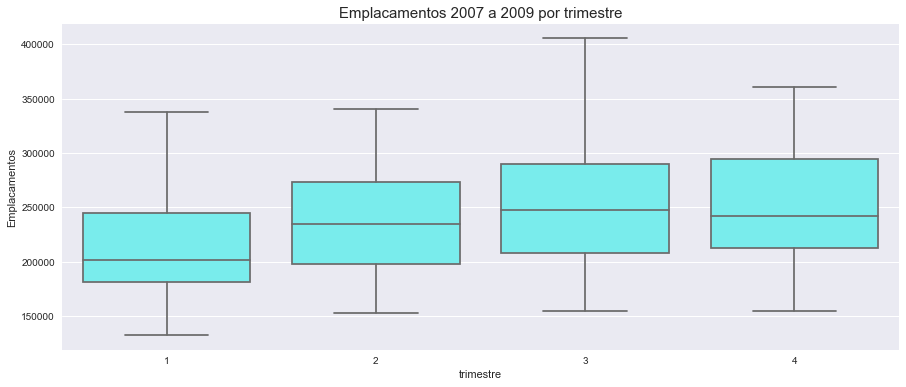

In [11]:
# Agrupando os dados por trimestre podemos notar que o volume de emplacamentos é maior no 4º trimestre do ano.
df['trimestre'] = df.index.quarter
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x='trimestre', y='Emplacamentos', color="#66FFFF")
ax.set_title('Emplacamentos 2007 a 2009 por trimestre', fontsize=15)
plt.show()

### 4) Processamento dos dados

Primeiro vou decompor a série de dados para evidenciar existência de sazonalidade e tendência.

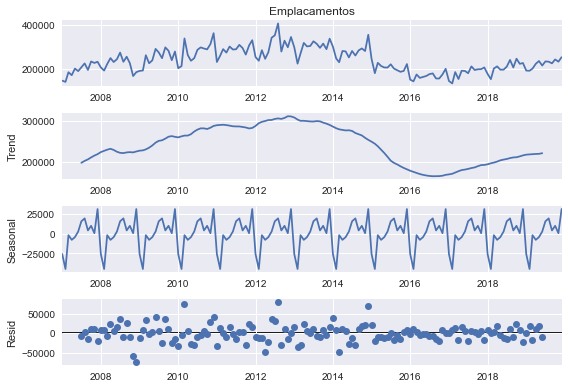

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_seasonal = seasonal_decompose(df['Emplacamentos'])
df_seasonal.plot();

Para carregar os dados no modelo, é necessário que a série esteja "limpa" (sem tendência).<br>
O cálculo de estacionariedade da série permite comprovar, de forma estatística, se a série precisará ser tratada.<br>
De forma resumida:<br>
Se P-value < 0.05 série estacionária.<br>
Se P-value > 0.05 série NÃO estacionária (é necessário tratar a série).

In [13]:
# Para verificar a estacionariedade da série de dados, utilizaremos o Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller
dfs = df['Emplacamentos']
adftest = adfuller(dfs)
print('O valor de ADF é: %.3f' % adftest[0])
print('O valor de P é: %.3f' % adftest[1])

O valor de ADF é: -1.432
O valor de P é: 0.567


<AxesSubplot:xlabel='Date'>

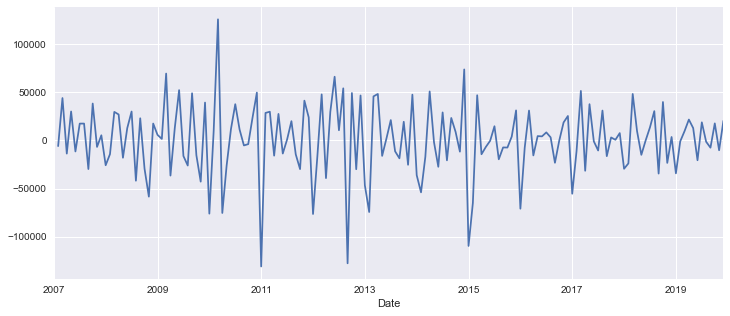

In [14]:
# aplicando a função diff para tratar a série e transformá-la em estacionária.
dfs1=dfs.diff()
dfs1.plot(figsize=(12,5))

In [15]:
# calculando novamente o valor de P após o processamento.
adftest2 = adfuller(dfs1.dropna())
print('O valor de P é: %.3f' % adftest2[1])

O valor de P é: 0.032


Verificado o P-value = 0.03 . Agora a série é ESTACIONÁRIA, e pode ser utilizada no modelo.

In [16]:
df2=dfs1.dropna()
df2.head()

Date
2007-02-01    -5845.0
2007-03-01    44142.0
2007-04-01   -13685.0
2007-05-01    30154.0
2007-06-01   -11450.0
Name: Emplacamentos, dtype: float64

### 5) Treino do modelo Definindo os dados  de treino e teste do modelo

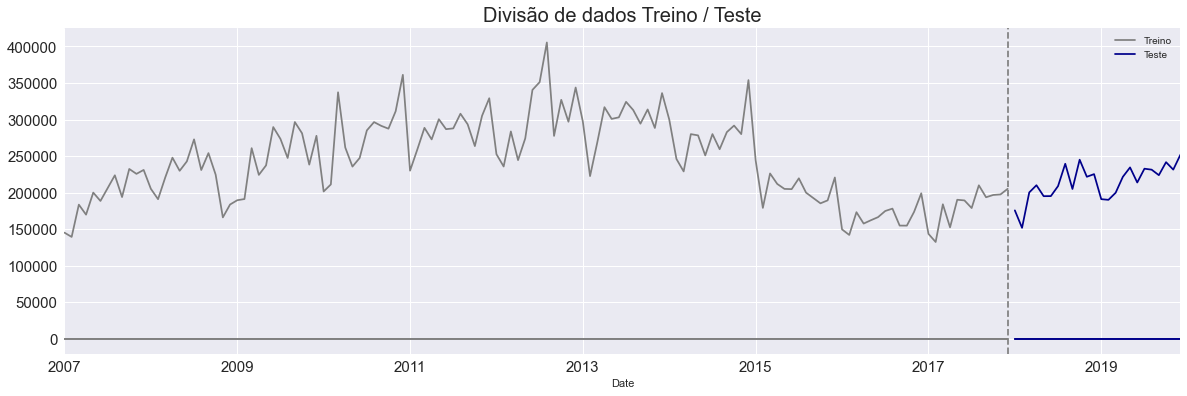

In [17]:
#Definindo o período até dez/2017 para treino e de jan/2018 em diante para teste do modelo.
train = df.loc[df.index < '2018-01-01']
test = df.loc[df.index >= '2018-01-01']
fig, ax = plt.subplots(figsize=(20, 6))
train.plot(ax=ax, label='Treino',fontsize=15, color='gray')
test.plot(ax=ax, label='Teste',color='darkblue')
plt.title('Divisão de dados Treino / Teste', fontsize=20)
ax.axvline('2017-12-01', color='gray', ls='--')
ax.legend(['Treino', 'Teste'])
leg = ax.get_legend()
leg.legendHandles[1].set_color('darkblue')
plt.show()

In [18]:
df.index = pd.to_datetime(df.index)

### 6) Calculando o modelo preditivo

In [19]:
#definindo as variáveis de treino/teste e os atributos a serem considerados no modelo.
atributos = ['trimestre','mes']
target = 'Emplacamentos'
X_train = train[atributos]
y_train = train[target]
X_test = test[atributos]
y_test = test[target]

In [20]:
# XGBoost Regressor é o modelo de Machine Learning do tipo Árvores de Decisão (decision tree) que será utilizado neste caso.
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:246452.90946	validation_1-rmse:213092.36858
[100]	validation_0-rmse:104395.44712	validation_1-rmse:63375.60360
[200]	validation_0-rmse:63199.03395	validation_1-rmse:15643.29026
[270]	validation_0-rmse:55999.18846	validation_1-rmse:18156.14744


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

#### Visualizando o peso de cada variável

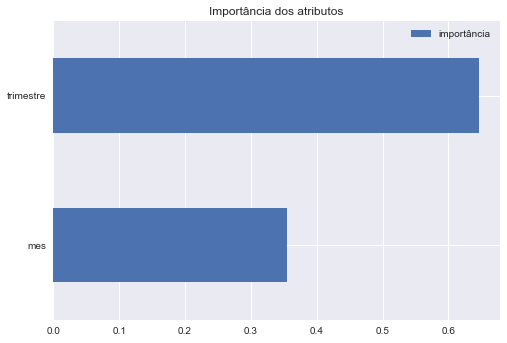

In [21]:
# visualizando o quão importante os atributos foram no cálculo do modelo
mfi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importância'])
mfi.sort_values('importância').plot(kind='barh', title='Importância dos atributos')
plt.show()

#### Testando o modelo

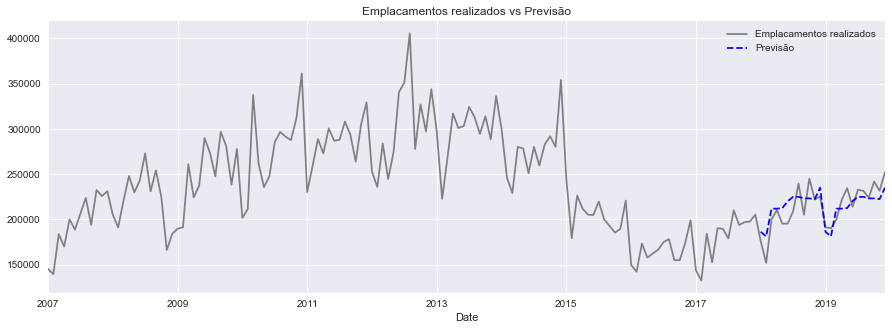

In [22]:
# Aplicando o algoritmo nos resultados de jan/18 a dez/19 para conferir a acurácia.
test['previsao'] = reg.predict(X_test).astype(int)
df = df.merge(test[['previsao']], how='left', left_index=True, right_index=True)
ax = df[['Emplacamentos']].plot(figsize=(15, 5),color='gray')
df['previsao'].plot(ax=ax, style='--',color='blue')
plt.legend(['Emplacamentos realizados', 'Previsão'])
ax.set_title('Emplacamentos realizados vs Previsão')
plt.show()

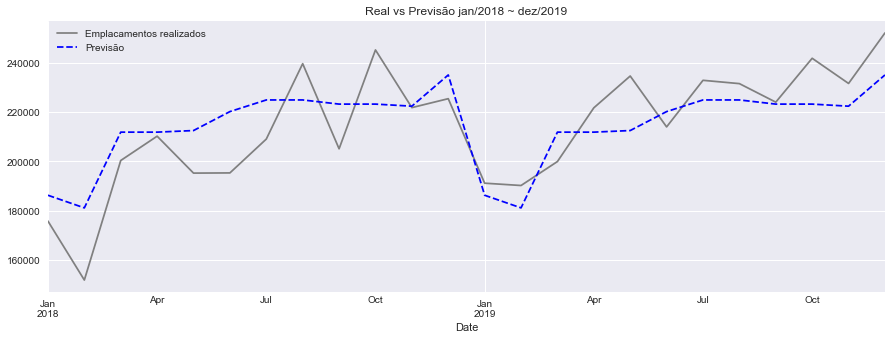

In [23]:
#Visualizando com mais detalhes a previsão vs emplacamentos realizados.
ax = df.loc[(df.index > '12-01-2017') & (df.index < '31-12-2019')]['Emplacamentos'] \
    .plot(figsize=(15, 5),color='gray', title='Real vs Previsão jan/2018 ~ dez/2019')
df.loc[(df.index > '12-01-2017') & (df.index < '31-12-2019')]['previsao'] \
    .plot(style='--',color='blue')
plt.legend(['Emplacamentos realizados','Previsão'])
plt.show()

#### Cálculo da acurácia do modelo

In [24]:
# O RMSE é o erro médio absoluto do modelo sobre os dados.
dfteste = df['2018-01-01' :'2019-12-01'].mean()
media_teste = dfteste['Emplacamentos']
score = np.sqrt(mean_squared_error(test['Emplacamentos'], test['previsao']))
acuracia = abs(score/media_teste-1)
print(f'O RMSE calculado foi: {score:0.0f} resultando em acurácia de {acuracia:,.1%}')

O RMSE calculado foi: 14542 resultando em acurácia de 93.2%


In [25]:
#visualizando os 5 meses onde o modelo mais ACERTOU
test['erro'] = np.abs(test[target] - test['previsao'])
test['erro%'] = (test['erro'] / test['Emplacamentos']).transform(lambda x: '{:,.1%}'.format(x))
dfa = test.sort_values(by=['erro'],ascending=True).head(5)
dfa = dfa.drop(['trimestre','mes'], axis=1)
dfa

,Emplacamentos,previsao,erro,erro%
Date,,,,
2018-11-01,221808,222387,579,0.3%
2019-09-01,224014,223229,785,0.4%
2018-04-01,210238,211877,1639,0.8%
2019-01-01,191209,186323,4886,2.6%
2019-06-01,213995,220198,6203,2.9%


In [26]:
#visualizando os 5 meses onde o modelo mais ERROU
test['erro'] = np.abs(test[target] - test['previsao'])
test['erro%'] = (test['erro'] / test['Emplacamentos']).transform(lambda x: '{:,.1%}'.format(x))
dfe = test.sort_values(by=['erro'],ascending=False).head(5)
dfe = dfe[['Emplacamentos','previsao','erro','erro%']]
dfe

,Emplacamentos,previsao,erro,erro%
Date,,,,
2018-02-01,151994,181213,29219,19.2%
2018-06-01,195369,220198,24829,12.7%
2019-05-01,234599,212521,22078,9.4%
2018-10-01,245159,223229,21930,8.9%
2019-10-01,241786,223229,18557,7.7%


### 7) Considerações

A acurácia do modelo pode aumentar significativamente, ao se adicionar outros atributos correlacionados à variável que estamos tentando prever (oferta de crédito para financiamento, promoções, descontos,entresafras,etc), bem como o ajuste nos parâmetros do modelo.<br>
Modelos preditivos dão um bom norte para o cálculo, porém, o mais importante é entender os desvios e retroalimentar os modelos com variáveis antes desconhecidas, consolidando modelos mais robustos para suportar as decisões de negócio.
